# Open Boundary Conditions: A Survey #
An introduction to lateral boundary conditions using a simple shallow water equation model.
Closed, periodic, passive and active boundaries are considered.

In [1]:
''' some basic imports, numpy to do math and the rest for plotting
and import our helper module with "everything but" the boundary conditions
I include def and return lines for those functions here, you can find
the whole functions in swe_module.py
'''

import matplotlib.pyplot as plt
import numpy as np

import swe_module as sw

%matplotlib inline

Our model system is a simple flat bottom box with a single layer of fluid.  The shallow water equation system.  We will neglect any explicit viscosity, and the nonlinear advection terms but include the Coriolis Force.  If your research is generally too small to feel the Coriolis force, set your box small and it will have a negligible impact.  We will force the fluid with a Gaussian addition (rain or runoff) in the centre of the domain.

So the governing equations are
\begin{equation}
\frac{\partial u}{\partial t} - f v = - g \frac{\partial \eta}{\partial x}
\end{equation}
\begin{equation}
\frac{\partial v}{\partial t} + f u = - g \frac{\partial \eta}{\partial y}
\end{equation}
\begin{equation}
\frac{\partial \eta}{\partial t} + H \left( \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0
\end{equation}
where $(u, v)$ is the horizontal velocity in $(x, y)$ directions, $f$ is the Coriolis parameter, $g = 9.8$m s$^{-2}$ is the acceleration due to gravity and $H$ is the depth of the fluid. 

The box has width and length $length$ and depth $H$.

In [2]:
# Nice small system, keep npts small
npts = 32
# Standard Parameters
g = 9.8 # m/s2
# Choose your latitude
lat = 40 # degrees N
f = 2 * 7.27e-5 * np.sin(np.deg2rad(lat))
# Choose your Box Size
length = 2000e3 # m
H = 200 # m

The shallow water equations allow shallow water surface waves.  Without rotation these waves have wavespeed, $c = (gH)^{1/2}$.  With rotation two types of waves are possible, Poincare waves and coastally trapped Kelvin waves.  Kelvin waves have the same wave speed.  Poincare waves are slower but approach $c$ as wavelengths decrease.

We will solve the system on an Arakawa C-Grid with the u-velocity staggered 1/2 grid point in x from the $\eta$ point and the v-velocity staggered 1/2 grid point in y.  Like this:  
v   
|   
|   
$\eta$ $-$ $-$ u   

We will use an explicit leap-frog scheme and so must choose our timestep, $dt$, small enough to meet the CFL condition. The leap-frog scheme requires two-previous steps so we need two sets of arrays. For one set of boundary conditions we require yet another previous time step, so we will use three sets of arrays.


In [3]:
# Derived Quantities
dx = length/npts
wavespeed = np.sqrt(g*H)
dt = 0.25*dx/wavespeed

## Initialization

*Set up our arrays* 

```python
def set_arrays(npts):  
return eta_now, u_now, v_now, eta_prev,  
           u_prev, v_prev, eta_next, u_next, v_next
```

## Internal Forcing

Our forcing will be an initial surface height increase of Gaussian shape, offset so its in the southwest quadrant of the box.

*Initialize Gaussian*
```python
def initialize(magnitude, gausshalfwidth, eta):
   return eta_init
```

*A 2-dimensional Gaussian if you want it*
```python
def initialize_simple(magnitude, gausshalfwidth, eta):
return eta_init
```

## External Forcing ##
The external forcing is a long wave length wave coming in from the west.

### Large scale wave ###
$\eta = \eta_o \sin(kx - \omega t)$

$k = 2\pi/(10 L)$

$c = \sqrt(gH)$

$\omega = c/k$

$\left( \frac {\partial^2}{\partial t^2} + f^2\right) u = - g \left( 
\frac {\partial^2 \eta}{\partial t \partial x} + f \frac{\partial \eta}{\partial y}\right)$

$\left( \frac {\partial^2}{\partial t^2} + f^2\right) v = - g \left( 
\frac {\partial^2 \eta}{\partial t \partial y} - f \frac{\partial \eta}{\partial x}\right)$



*Incoming Large Scale Wave*
```python
def incoming_wave(t, npts, dx):
    return eta_wave, u_wave, v_wave
```

## Time Stepping

To start the code, we do a predictor-corrector which requires an Euler step

*Euler Step*
```python
def euler(eta, u, v, idt, f, g, H, dx):
    return eta_next, u_next, v_next
```

*Leap-frog Step*
```python
def leapfrog(eta, u, v, etap, up, vp, idt, f, g, H, dx):
    return eta_next, u_next, v_next
```

## Boundary Conditions ##

The equations above neglect lateral viscosity and advection.  These approximations, plus the choice of the c-grid, greatly reduce the number of boundary conditions we need.  We only need to set the normal velocity at each of the four edges of the box.

The figure below shows the western wall of the box

$u_o$ is a real boundary point.  $v_o$ and $\eta_o$ are ghost points.  Neither are needed in the "stencil" to find interior points.  So we just don't use them or set them.

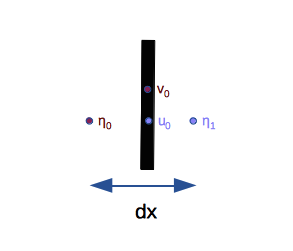

In [4]:
filename = '../WS-MEOPAR/grid_lateral.png'
from IPython.display import Image
Image(filename=filename)

In [5]:
def boundary_conditions_periodic(u, v, **kwargs):
    '''Periodic boundary conditions wrap the solution, 
    copying the first internal point on the eastern boundary
    to the boundary point on the western boundary'''
    u[0] = u[-2]
    u[-1] = u[1]
    v[:, 0] = v[:, -2]
    v[:, -1] = v[:, 1]
    return u, v

In [6]:
def boundary_conditions_freeslip(u, v, **kwargs):
    '''These conditions impose wall boundaries with zero flow 
    through the walls'''
    u[0] = 0
    u[-1] = 0
    v[:, 0] = 0
    v[:, -1] = 0
    return u, v

In [7]:
def boundary_conditions_zerogradient(u, v, **kwargs):
    '''A simple, not particularly good, open boundary type where 
    the value outside the boundary is the same as inside'''
    u[0] = u[1]
    u[-1] = u[-2]
    v[:, 0] = v[:, 1]
    v[:, -1] = v[:, -2]
    return u, v

In [8]:
def boundary_conditions_cnstgradient(u, v, **kwargs):
    '''A simple open boundary type where the value outside the boundary 
    is different from the value inside the boundary by the same amount
    as the value inside is from the next value'''
    u[0] = 2 * u[1] - u[2]
    u[-1] = 2 * u[-2] - u[-3]
    v[:, 0] = 2 * v[:, 1] - v[:, 2]
    v[:, -1] = 2 * v[:, -2] - v[:, -3]
    return u, v

In [9]:
def boundary_conditions_sommerfield(u_next, v_next, u_now, v_now, u_prev,
                                    v_prev, dx, dt, wavespeed, **kwargs):
    '''A wave radiation boundary condition.  Signals are moved out at the 
    assumed wavespeed'''
    # cn is c*dt/dx or normalized wavespeed
    cn = -wavespeed * dt / dx
    u_next[0] = (1 + cn) / (1 - cn) * u_prev[0] - 2 * cn / (1 - cn) * u_now[1]
    u_next[-1] = (1 + cn) / (1 - cn) * u_prev[-1] - 2 * cn / (1 - cn
                                                              ) * u_now[-2]
    v_next[:, 0] = (1 + cn) / (1 - cn) * v_prev[:, 0] - 2 * cn / (
        1 - cn) * v_now[:, 1]
    v_next[:, -1] = (1 + cn) / (1 - cn) * v_prev[:, -1] - 2 * cn / (
        1 - cn) * v_now[:, -2]
    return u_next, v_next

In [10]:
def boundary_conditions_orlanski(u_next, v_next, u_now, v_now, u_prev, v_prev,
                                 dx, dt, **kwargs):
    '''The classic wave radiation boundary condition.  A wave speed is estimated.
    If that wavespeed is toward the boundary, signals are moved out at that
    wavespeed. There is a limited on the wavespeed.'''
    # cn is c*dt/dx or normalized wavespeed
    epsilon = 1e-12
    # c here is c*dt/dx
    cn = (u_next[1] - u_prev[1]) / (
        u_next[1] + u_prev[1] - 2 * u_now[2] + epsilon)
    for j in range(u_next.shape[1]):
        if cn[j] > 0:
            cn[j] = 0
        elif cn[j] < -1:
            cn[j] = -1
    u_next[0] = (1 + cn) / (1 - cn) * u_prev[0] - 2 * cn / (1 - cn) * u_now[1]

    cn = (u_next[-2] - u_prev[-2]) / (
        u_next[-2] + u_prev[-2] - 2 * u_now[-3] + epsilon)
    for j in range(u_next.shape[1]):
        if cn[j] > 0:
            cn[j] = 0
        elif cn[j] < -1:
            cn[j] = -1
    u_next[-1] = (1 + cn) / (1 - cn) * u_prev[-1] - 2 * cn / (1 - cn) * u_now[-2]

    c = (v_next[:, 1] - v_prev[:, 1]) / (
        v_next[:, 1] + v_prev[:, 1] - 2 * v_now[:, 2] + epsilon)
    for i in range(v_next.shape[0]):
        if cn[i] > 0:
            cn[i] = 0
        elif cn[i] < -1:
            cn[i] = -1
    v_next[:, 0] = (1 + cn) / (1 - cn) * v_prev[:, 0] - 2 * cn / (1 - cn
                                                               ) * v_now[:, 1]

    cn = (v_next[:, -2] - v_prev[:, -2]) / (
        v_next[:, -2] + v_prev[:, -2] - 2 * v_now[:, -3] + epsilon)
    for i in range(v_next.shape[0]):
        if cn[i] > 0:
            cn[i] = 0
        elif cn[i] < -1:
            cn[i] = -1
    v_next[:, -1] = (1 + cn) / (1 - cn) * v_prev[:, -1] - 2 * cn / (
        1 - cn) * v_now[:, -2]

    return u_next, v_next

In [11]:
def boundary_conditions_frs_sommerfield(u_next, v_next, u_now, v_now, u_prev,
                                        v_prev, dx, dt, wavespeed, eta_next,
                                        rim, t, **kwargs):
    '''Combined boundary conditions.  Sommerfield radiation and then
    Relaxation to an applied external field'''

    cn = -wavespeed * dt / dx

    u_next[-1] = (1 + cn) / (1 - cn) * u_prev[-1] - 2 * cn / (1 - cn
                                                              ) * u_now[-2]

    v_next[:, 0] = (1 + cn) / (1 - cn) * v_prev[:, 0] - 2 * cn / (
        1 - cn) * v_now[:, 1]

    v_next[:, -1] = (1 + cn) / (1 - cn) * v_prev[:, -1] - 2 * cn / (
        1 - cn) * v_now[:, -2]

    weight = np.array([np.tanh((np.arange(rim)) * 0.5), ] *
                      u_next.shape[0]).transpose()

    eta_wave, u_wave, v_wave = sw.incoming_wave(t, u_next.shape[0], dx, f, g,
                                                wavespeed)
    u_next[:rim] = u_wave[:rim] * (1 - weight) + u_next[:rim] * weight
    v_next[:rim] = v_wave[:rim] * (1 - weight) + v_next[:rim] * weight
    eta_next[:rim] = eta_wave[:rim] * (1 - weight) + eta_next[:rim] * weight

    return eta_next, u_next, v_next

In [12]:
def boundary_conditions_flather_sommerfield(
        u_next, v_next, u_now, v_now, u_prev, v_prev, dx, dt, eta_next,
        wavespeed, rim, t, eta_now):
    '''Combined boundary conditions.  Sommerfield radiation and Flather conditions
    for an applied external barotropic surface height field'''

    cn = -wavespeed * dt / dx

    u_next[-1] = (1 + cn) / (1 - cn) * u_prev[-1] - 2 * cn / (1 - cn
                                                              ) * u_now[-2]

    v_next[:, 0] = (1 + cn) / (1 - cn) * v_prev[:, 0] - 2 * cn / (
        1 - cn) * v_now[:, 1]

    v_next[:, -1] = (1 + cn) / (1 - cn) * v_prev[:, -1] - 2 * cn / (
        1 - cn) * v_now[:, -2]

    eta_wave, u_wave, v_wave = sw.incoming_wave(t, u_next.shape[0], dx, f, g,
                                                wavespeed)

    u_next[0] = u_wave[0] - np.sqrt(g / H) * (eta_now[1] - eta_wave[0])

    return eta_next, u_next, v_next

In [25]:
def boundary_conditions(kind, u_next, v_next, u_now, v_now, u_prev, v_prev, dx,
                        dt, wavespeed, eta_next, rim, t, eta_now):
    '''Generalized driver for boundary condtions'''
    bc_funcs = {
        'periodic': boundary_conditions_periodic,
        'freeslip': boundary_conditions_freeslip,
        'zerogradient': boundary_conditions_zerogradient,
        'cnstgradient': boundary_conditions_cnstgradient,
        'sommerfield': boundary_conditions_sommerfield,
        'orlanski': boundary_conditions_orlanski,
        'frs_sommerfield': boundary_conditions_frs_sommerfield,
        'flather_sommerfield': boundary_conditions_flather_sommerfield,
    }
    with_eta = ['frs_sommerfield', 'flather_sommerfield']
    if kind in with_eta:
        eta_next, u_next, v_next = bc_funcs[kind](u_next,
                                                  v_next,
                                                  u_now=u_now,
                                                  v_now=v_now,
                                                  u_prev=u_prev,
                                                  v_prev=v_prev,
                                                  dx=dx,
                                                  dt=dt,
                                                  wavespeed=wavespeed,
                                                  eta_next=eta_next,
                                                  rim=rim,
                                                  t=t,
                                                  eta_now=eta_now)
    else:
        u_next, v_next = bc_funcs[kind](u_next,
                                        v_next,
                                        u_now=u_now,
                                        v_now=v_now,
                                        u_prev=u_prev,
                                        v_prev=v_prev,
                                        dx=dx,
                                        dt=dt,
                                        wavespeed=wavespeed,
                                        eta_next=eta_next,
                                        rim=rim,
                                        t=t,
                                        eta_now=eta_now)
    return eta_next, u_next, v_next

# Main Program #

In [ ]:
# Chose how many time steps
ntime = 10
# Chose boundary conditions
boundary_type = 'periodic'
rim = 3

# initialize array
eta_now, u_now, v_now, eta_prev, u_prev, v_prev, eta_next, u_next, v_next = sw.set_arrays(
    npts)

# add our internal forcing
eta_prev = sw.initialize(magnitude=1.0, gausshalfwidth=3.5, eta=eta_now)

# take an Euler step from 0 to dt
eta_now, u_now, v_now = sw.euler(eta_prev, u_prev, v_prev, dt, f, g, H, dx)
# and boundary conditions
eta_now, u_now, v_now = boundary_conditions(
    boundary_type, u_now, v_now, u_now, v_now, u_prev, v_prev, dx, dt / 2,
    wavespeed, eta_now, rim, dt, eta_prev)

# Average to give us the 1/2 dt value in now
for var_now, var_prev in zip([eta_now, u_now, v_now],
                             [eta_prev, u_prev, v_prev]):
    var_now = 0.5 * (var_now + var_prev)

# Take a first leap-frog step
eta_next, u_next, v_next = sw.leapfrog(eta_now, u_now, v_now, eta_prev, u_prev,
                                       v_prev, dt, f, g, H, dx)
# Increment Time
t = dt
# Boundary Conditions
eta_next, u_next, v_next = boundary_conditions(
    boundary_type, u_next, v_next, u_now, v_now, u_prev, v_prev, dx, dt / 2,
    wavespeed, eta_next, rim, t, eta_now)

# and now we are started we can loop
for i in range(ntime):
    eta_prev, u_prev, v_prev = eta_now, u_now, v_now
    eta_now, u_now, v_now = eta_next, u_next, v_next

    eta_next, u_next, v_next = sw.leapfrog(eta_now, u_now, v_now, eta_prev,
                                           u_prev, v_prev, 2 * dt, f, g, H, dx)
    t = t + dt
    eta_next, u_next, v_next = boundary_conditions(
        boundary_type, u_next, v_next, u_now, v_now, u_prev, v_prev, dx, dt,
        wavespeed, eta_next, rim, t, eta_now)

    # every 101 time steps average and restart to remove the leap frog 
    # computational mode
    if (np.mod(i, 101) == 0):
        for var_now, var_next in zip([eta_now, u_now, v_now],
                                     [eta_next, u_next, v_next]):
            var_next = 0.5 * (var_now + var_next)
        eta_next, u_next, v_next = sw.leapfrog(
            eta_next, u_next, v_next, eta_now, u_now, v_now, dt, f, g, H, dx)
        eta_next, u_next, v_next = boundary_conditions(
            boundary_type, u_next, v_next, u_next, v_next, u_now, v_now, dx,
            dt, wavespeed, eta_next, rim, t, eta_next)

# Plotting #

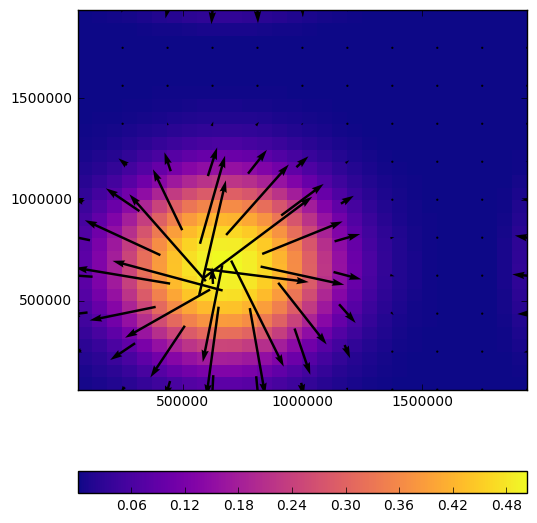

In [26]:
sw.make_plot(npts, dx, eta_next, u_next, v_next)

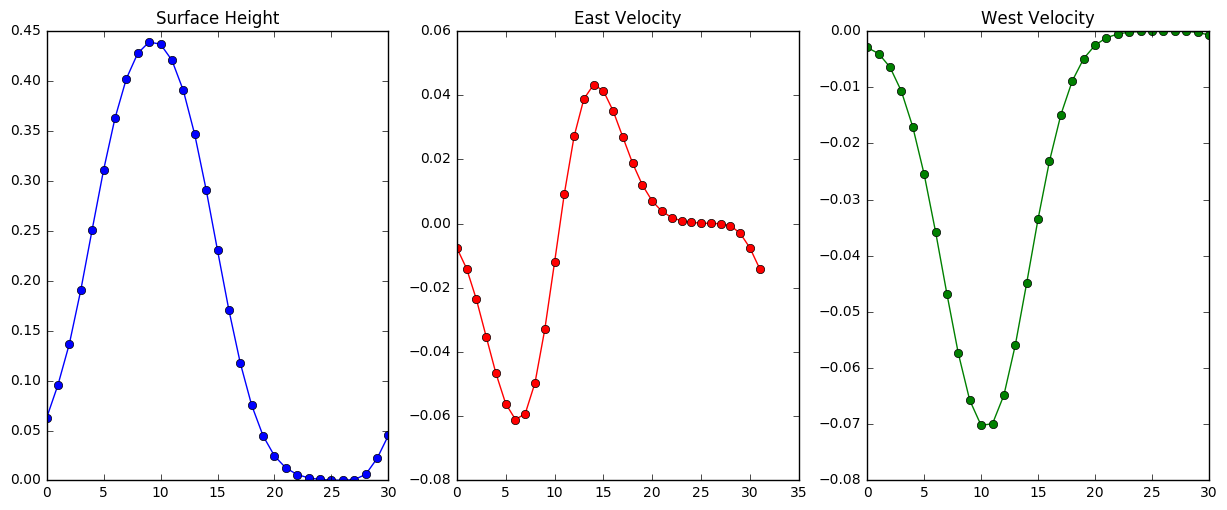

In [27]:
sw.make_line_plots(eta_next, u_next, v_next, 'eastwest', ii=7)

# The Questions #

## A. Simple Boundary Conditions ##

I have included a suite of simple boundary conditions:
* periodic
* freeslip
* zerograd
* cnstgrad

For each of these boundary conditions, open a cell below.  Choose markdown and answer the following questions (the first one **before** you run the code).  You may wish to change the length of time you run for "ntime"
* What do you expect to see at the boundary?
* What do you see at the boundary when you run the code?
* What would you use these boundary conditions for?  

## B. Radiation Boundary Conditions ##

I have included two radiation type boundary conditions:
* sommerfield which uses the known wavespeed
* orlanski which calculates the wavespeed

Open a cell below and answer these questions:
* What should radiation boundary conditions do?
* Which of the two methods works better?  In what way is it better?
* Under which conditions, would you use the other method?

# C. Bringing Information In #

I have included two types of boundary conditions that bring external information in.
* frs 
* flather

In each case, I am bringing in a large wave from the west.  Note that you still have your internal forcing.

Open a cell below and answer these questions:
* Ideally what should happen?
* Do you get what you expect?

# D. Toward the Real World #

The major simplification that matters here, is that this system has only one wave speed.

* Why does adding multiple wave speeds make open boundaries more difficult?